<img src="https://logodownload.org/wp-content/uploads/2018/02/reddit-logo.png" width="600"/>

# Reddit Webscraping


# Introduction
Fairy tales teach children about romantic love. The princess is in danger, the prince comes to the rescue, and they live happily ever after.

But as you grow up, you realise that love is not as simple as saving the person dear to you from her stepmother, an apple, or a curse. Love involves a lot of trial and error, meeting halfway, and swallowing one’s pride. Everything is complicated.


How do you know when it’s really all over?  Is it when one of you calls it quits?  Or, is there still hope even when someone has walked out?  This project will look into it, break up or make up

There are numerous reasons that relationships break up.  Some of them are even good reasons.  For instance, if you are just leading your partner on, it is right to cut him or her loose.  If he or she isn’t trustworthy, that is a good reason for a break up.  Of course, sometimes people’s lives change and the partner no longer fits into the total picture, in which case, it is good to end the relationship.

We will use data from the below mentioned subreddit for this project:

- Subreddit used:
  - Relationship advice: looking for opinions on how to improve or resolve relationship issue
  - Breakups: mentioning why the breakup happen, and why it is not resolved


<img src="http://3.bp.blogspot.com/-qppebMLzuGU/USy6vN-xmmI/AAAAAAAAAdM/HONipAqwV3k/s1600/break-up-mix-art-copy-300x289.jpg" />

## Problem Statement

Create a classification model to determine the text being relationship advice or breakup.

## Executive Summary

The data is webscrapped from 2 reddit subreddit post relationship_advice and BreakUp. A series of transformation, including StopWords removal, Stemming and Vectorization, is done to the raw data to create bag-of-words. A few model is used, mainly LogisticRegression, Naive Bayes and a few DecisionTrees models to see which model gives us the best accuracy to differentiate the 2 different type of subreddit post. MultinomialNB was selected as the best model, which gives us the best accuracy. LogisticRegression was used to analyze the keywords as the model will let us know the importance of the keywords

### Content summary
- Webscrapped from relationship_advice & BreakUp reddit
- Data cleaning
  - Stopwords removal
  - Stemming
  - lowercase
  - punctuation removal
  
- Modeling

  - Vectorizor
    - CountVectorizor
    - TFIDVectorizor
    - Hashing Vectorizor
  - Models
    - LogisticRegression 
    - MultinomialNB 
    - KNN 
    - SVC 
    - DecisionTree  
    - Bagging 
    - ADABoost

### Accuracy of models
- MultinomialNB 
  - 86% for relationship_advice 
  - 83% for BreakUp
- LogisticRegression
  - 86.5% for relationship_advice 
  - 78% for BreakUp
  
### Key findings

- The findings shown that relationship_advice tend to mention more about the other person(Boyfriend,spouse,wife,gf,bf) as opposed to Breakup when it is more self focused(dream, memory,sad, better, move on).
- There is a small misclassification of the model, and after taking a manual check on the post, it can be interpreted that the post would have been better classified under the opposite thread instead. 
- Its interesting to note that around the 6am - 12pm time period, not much relationship advices are posted. This interpretation would be better look into by a psychology specialist to see if there is a relationship in time of post with the content.

### Content
<br>2. Data Cleaning
<br>3. Preprocessing of text data
<br>4. EDA
<br>5. Model
<br>6. Analysis and Recommendation

# 2. Data Cleaning

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from PIL import Image
from wordcloud import WordCloud

from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import RegexpTokenizer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, roc_auc_score, plot_roc_curve, plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

## 2.1 Manual Inspection of data

In [2]:
thread_1 = 'relationship_advice'
thread_2 = 'BreakUps'

df_t1= pd.read_csv('../data/' + (str(thread_1)) + '.csv')
df_t2 = pd.read_csv('../data/' + (str(thread_2)) + '.csv')

In [3]:
df_t1.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
0,NaN,relationship_advice,**TL;DR on Throwaways:** If you wish to reques...,t2_4det0,False,NaN,0,False,"[meta] It's not required, but if you make a ne...",[],...,/r/relationship_advice/comments/d3okss/meta_it...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3883628,1.568378e+09,7,NaN,False,NaN
1,NaN,relationship_advice,We get the stress from social isolation is bad...,t2_4det0,False,NaN,0,False,[meta] One (1) day bans for moral judgment pos...,[],...,/r/relationship_advice/comments/g7ukh7/meta_on...,all_ads,True,https://www.reddit.com/r/relationship_advice/c...,3883628,1.587826e+09,0,NaN,False,NaN
2,NaN,relationship_advice,opps I made a typo in the title sorry! I meant...,t2_7wa6olo9,False,NaN,0,False,My (27/F) cousin (27/F) confessed that she was...,[],...,/r/relationship_advice/comments/iiscjb/my_27f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598708e+09,0,NaN,False,NaN
3,NaN,relationship_advice,"I (F, 32) have been married to my husband (M,3...",t2_60t4vdow,False,NaN,0,False,My mom is accusing my husband of abusing our d...,[],...,/r/relationship_advice/comments/iiwkf7/my_mom_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598723e+09,0,NaN,False,NaN
4,NaN,relationship_advice,He said the hard r while reading a message tha...,t2_7q6y01ro,False,NaN,0,False,Broke up with my boyfriend because he’s racist,[],...,/r/relationship_advice/comments/ij4pj2/broke_u...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598753e+09,0,NaN,False,NaN


In [4]:
df_t1.shape

(995, 103)

In [5]:
# dropping first and second column as it is the rules as regulations for the thread
df_t1.drop(index = [0, 1], inplace = True)
df_t1.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,permalink,parent_whitelist_status,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,author_cakeday
2,NaN,relationship_advice,opps I made a typo in the title sorry! I meant...,t2_7wa6olo9,False,NaN,0,False,My (27/F) cousin (27/F) confessed that she was...,[],...,/r/relationship_advice/comments/iiscjb/my_27f_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598708e+09,0,NaN,False,NaN
3,NaN,relationship_advice,"I (F, 32) have been married to my husband (M,3...",t2_60t4vdow,False,NaN,0,False,My mom is accusing my husband of abusing our d...,[],...,/r/relationship_advice/comments/iiwkf7/my_mom_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598723e+09,0,NaN,False,NaN
4,NaN,relationship_advice,He said the hard r while reading a message tha...,t2_7q6y01ro,False,NaN,0,False,Broke up with my boyfriend because he’s racist,[],...,/r/relationship_advice/comments/ij4pj2/broke_u...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598753e+09,0,NaN,False,NaN
5,NaN,relationship_advice,So where to begin...\nI (27f) am not a touchy ...,t2_76xo5mq0,False,NaN,0,False,Male friend expects/demands I hug him even tho...,[],...,/r/relationship_advice/comments/ij2bxh/male_fr...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598743e+09,0,NaN,False,NaN
6,NaN,relationship_advice,I am currently in a three-year relationship wi...,t2_7uu5n1yd,False,NaN,0,False,My [26m] girlfriend [24f] has opened up to me ...,[],...,/r/relationship_advice/comments/iinhzs/my_26m_...,all_ads,False,https://www.reddit.com/r/relationship_advice/c...,3883628,1.598681e+09,1,NaN,False,NaN


In [6]:
df_t2.head()

,approved_at_utc,subreddit,selftext,author_fullname,saved,mod_reason_title,gilded,clicked,title,link_flair_richtext,...,stickied,url,subreddit_subscribers,created_utc,num_crossposts,media,is_video,media_metadata,author_cakeday,poll_data
0,NaN,BreakUps,"Hey, I really miss you. I’m sorry for texting ...",t2_7uvvphr0,False,NaN,0,False,Drunk text! Posting on here instead of actuall...,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij4...,130178,1.598752e+09,0,NaN,False,NaN,NaN,NaN
1,NaN,BreakUps,I no longer have to compromise. I can do exact...,t2_aooid,False,NaN,0,False,Some positives about being single,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij2...,130178,1.598742e+09,1,NaN,False,NaN,NaN,NaN
2,NaN,BreakUps,"Everyday I hear the statement, ""I would do any...",t2_4i38okh,False,NaN,0,False,Why trauma (Breakup) is a good thing,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij5...,130178,1.598754e+09,0,NaN,False,NaN,NaN,NaN
3,NaN,BreakUps,"I can’t touch myself, intimately or otherwise,...",t2_39eluamz,False,NaN,0,False,I can’t take it.,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij3...,130178,1.598747e+09,0,NaN,False,NaN,NaN,NaN
4,NaN,BreakUps,\nDon’t ask them back when they showed you the...,t2_4euwc4gp,False,NaN,0,False,You’re being selfish by holding on to your ex.,[],...,False,https://www.reddit.com/r/BreakUps/comments/ij7...,130178,1.598764e+09,0,NaN,False,NaN,NaN,NaN


### 2.1.1 Check for Duplicates

In [7]:
print(f'No.of duplciated post in Thread {thread_1}: {df_t1.selftext.duplicated().sum()}')
print(f'No.of duplciated post in Thread {thread_2}: {df_t2.selftext.duplicated().sum()}')

No.of duplciated post in Thread relationship_advice: 29
No.of duplciated post in Thread BreakUps: 63


In [8]:
#dropping duplicates
df_t1.drop(index = df_t1[df_t1.selftext.duplicated()].index, inplace = True)
df_t2.drop(index = df_t2[df_t2.selftext.duplicated()].index, inplace = True)
print(f'No.of duplciated post in Thread {thread_1}: {df_t1.selftext.duplicated().sum()}')
print(f'No.of duplciated post in Thread {thread_2}: {df_t2.selftext.duplicated().sum()}')

No.of duplciated post in Thread relationship_advice: 0
No.of duplciated post in Thread BreakUps: 0


### 2.1.2 Check number of post

In [9]:
print(f'No. of rows in Thread {thread_1}: {df_t1.shape[0]}')
print(f'No. of rows in Thread {thread_2}: {df_t2.shape[0]}')

No. of rows in Thread relationship_advice: 964
No. of rows in Thread BreakUps: 935


### 2.1.3 Baseline of dataset

In [10]:
df = pd.concat([df_t1,df_t2])[['subreddit', 'selftext', 'created_utc']] # combining both dataframe together, using only relevent columns
print(f'Total No. of rows in DataFrame: {df.shape[0]}')
df.subreddit.value_counts(normalize = True)

Total No. of rows in DataFrame: 1899


relationship_advice    0.507636
BreakUps               0.492364
Name: subreddit, dtype: float64

### 2.1.4 Setting target variable as binary

In [11]:
#setting target variable as binary, 1 for thread 1, 0 for thread 2
df['subreddit'] = df['subreddit'].map({thread_1 : 1, thread_2: 0}) 

#resetting index
df.reset_index(drop=True, inplace = True)
df.subreddit.value_counts(normalize = True)

1    0.507636
0    0.492364
Name: subreddit, dtype: float64

### 2.1.5 Dealing will null values

In [12]:
#checking of null values
df.isna().sum()

subreddit      0
selftext       1
created_utc    0
dtype: int64

In [13]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
print(f'Null values left in df: {df.isna().sum().sum()}')
print(f'Number of rows left: {df.shape[0]}')

Null values left in df: 0
Number of rows left: 1898


# 3. EDA
## 3.1 Time of post

In [14]:
df['created_utc'] = pd.to_datetime(df['created_utc'], unit = 's')
df['created_hour'] = [d.hour for d in df['created_utc']]
df['created_minute'] = [d.minute for d in df['created_utc']]
df.head()

,subreddit,selftext,created_utc,created_hour,created_minute
0,1,opps I made a typo in the title sorry! I meant...,2020-08-29 13:26:18,13,26
1,1,"I (F, 32) have been married to my husband (M,3...",2020-08-29 17:36:57,17,36
2,1,He said the hard r while reading a message tha...,2020-08-30 01:56:54,1,56
3,1,So where to begin...\nI (27f) am not a touchy ...,2020-08-29 23:14:43,23,14
4,1,I am currently in a three-year relationship wi...,2020-08-29 06:08:03,6,8


In [15]:
#checking data not in 2020
df[df['created_utc'].dt.year < 2020]

,subreddit,selftext,created_utc,created_hour,created_minute
962,1,**TL;DR on Throwaways:** If you wish to reques...,2019-09-13 12:32:57,12,32


In [16]:
#checking data not in month of August 
df[df['created_utc'].dt.month < 8]

,subreddit,selftext,created_utc,created_hour,created_minute
963,1,We get the stress from social isolation is bad...,2020-04-25 14:40:58,14,40


In [17]:
#dropping data that is not within the timeframe of majority of data
df.drop(index = df[df['created_utc'].dt.year == 2019].index, inplace = True)
df.drop(index = df[df['created_utc'].dt.month < 8].index, inplace = True)

In [18]:
df['created_utc'].dt.year.value_counts()

2020    1896
Name: created_utc, dtype: int64

In [19]:
df['created_utc'].dt.month.value_counts()

8    1896
Name: created_utc, dtype: int64

All data is in August 2020

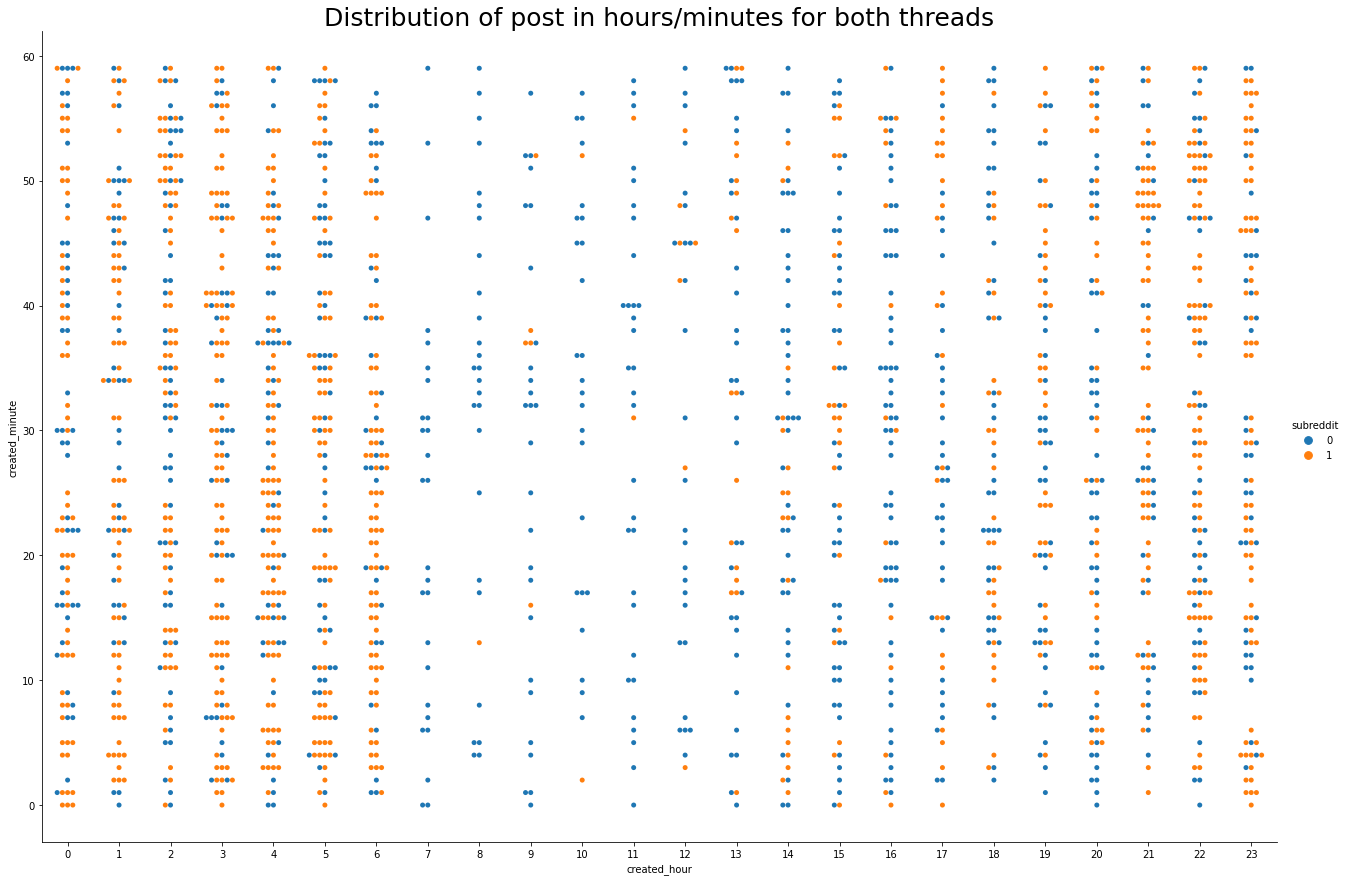

In [20]:
sorted_index = df['created_hour'].unique().sort()
fig = sns.catplot(x = 'created_hour',
                  y = 'created_minute',
                  hue = 'subreddit', #1 = thread_1,0 = thread_2 
                  data = df,
                  kind = 'swarm', 
                  height = 12,
                  aspect = 1.5,
                  order = sorted_index)

plt.title('Distribution of post in hours/minutes for both threads', fontdict = {'fontsize': 25})

ax= fig.axes[0][0]
ax.set_yscale('linear')
plt.show()

### 3.1 Comments
- Data collected are all in August 2020
- Interestingly, most relationship advice post are not posted inbetween 6am - 12pm 

## 3.2 Average length of post in each thread

In [21]:
len_of_t1_post = 0
len_of_t2_post = 0
t1_counter = 0
t2_counter = 0

for i in df.index:
    if df['subreddit'][i] == 1:
        t1_counter += 1
        len_of_t1_post += (len(df['selftext'][i].split())) #spliting the text data to words
    else:
        t2_counter += 1
        len_of_t2_post += (len(df['selftext'][i].split()))
        
print(f'Average number of words in {thread_1} post: {round(len_of_t1_post/t1_counter)}')
print(f'Average number of words in {thread_2} post: {round(len_of_t2_post/t2_counter)}')

Average number of words in relationship_advice post: 366
Average number of words in BreakUps post: 256


### 3.2 comments
post in Breakup threads has about 100 less words on average compared to relationship advices post

# 4. Preprocessing of data
## 4.2 Creating Bag-Of-Words model
### 4.1.1 Train test split data

In [22]:
#Train test split the data
X_train, X_test, y_train, y_test = train_test_split(df['selftext'],
                                                    df['subreddit'],
                                                    test_size = 0.2, 
                                                    random_state = 42,
                                                    stratify = df['subreddit'])

In [23]:
print(f'X_train rows: {X_train.shape[0]}, X_test rows: {X_test.shape[0]}')
print(f'y_train rows: {y_train.shape[0]}, y_test rows: {y_test.shape[0]}')

X_train rows: 1516, X_test rows: 380
y_train rows: 1516, y_test rows: 380


In [24]:
X_train.head()

1886    I see post about your ex not being the right p...
1369    We broke up a bit over a month ago. Things end...
1881    When I was with my ex, I loved baking, just cl...
433     I [18 F] can't get over this girl [18 F] I had...
749     I met a guy through a subreddit and we got alo...
Name: selftext, dtype: object

In [25]:
X_train.index[0]

1886

In [26]:
X_train[X_train.index[0]] #selecting first index row of train text

'I see post about your ex not being the right person and I’m trying to accept that but when I think about it, I get sad thinking that they weren’t the right person because I really wanted to them to be. Everything still reminds me of them but I guess it’s only been 2 months since the breakup so it’ll get better with time.'

### 4.1.2 Removing HTML Features

In [27]:
# Removing HTML features if present
example1 = BeautifulSoup(X_train[X_train.index[0]])


print('Before')
print(X_train[X_train.index[0]])
print()
print('AFTER')
print(example1.get_text())

Before
I see post about your ex not being the right person and I’m trying to accept that but when I think about it, I get sad thinking that they weren’t the right person because I really wanted to them to be. Everything still reminds me of them but I guess it’s only been 2 months since the breakup so it’ll get better with time.

AFTER
I see post about your ex not being the right person and I’m trying to accept that but when I think about it, I get sad thinking that they weren’t the right person because I really wanted to them to be. Everything still reminds me of them but I guess it’s only been 2 months since the breakup so it’ll get better with time.


### 4.1.3 Removing numerical values

In [28]:
letters_only = re.sub('[^a-zA-Z]',
                     " ",
                     example1.get_text())

letters_only[:50]

'I see post about your ex not being the right perso'

### 4.1.4 Lowercase text

In [29]:
#lowercase text
lower_case = letters_only.lower()
#splitting text to strings
words = lower_case.split()
words[:10]

['i', 'see', 'post', 'about', 'your', 'ex', 'not', 'being', 'the', 'right']

### 4.1.5 Removing stopwords

In [30]:
stop_words = stopwords.words('english') + ['relationship', 
                                            'relation', 
                                            'advice', 
                                            'breakup', 
                                            'break', 
                                            'broke']
words = [w for w in words if w not in stop_words]
words[:10]

['i', 'see', 'post', 'about', 'your', 'ex', 'not', 'being', 'the', 'right']

### 4.1.6 Stemming text

In [31]:
p_stemmer = PorterStemmer()
words_pstem = [p_stemmer.stem(i) for i in words]

In [32]:
# Print only those stemmed tokens that are different.
for i in range(len(words)):
    if words[i] != words_pstem[i]:
        print((words[i], words_pstem[i]))

('being', 'be')
('trying', 'tri')
('thinking', 'think')
('because', 'becaus')
('really', 'realli')
('wanted', 'want')
('everything', 'everyth')
('reminds', 'remind')
('only', 'onli')
('months', 'month')
('since', 'sinc')


## 4.2 Creating function for preprocessing of text

In [33]:
keywords = ['relationship', 'relation', 'advice', 'breakup', 'break', 'broke', 'ex' , 'reddit', 'ask']

stop_words = stopwords.words('english') + keywords
p_stemmer = PorterStemmer()


def words_cleaning(text):
    #removing HTML Features
    bs_text = BeautifulSoup(text).get_text()
    
    #Removing numerical values
    letters_only = re.sub('[^a-zA-Z]', " ", bs_text)

    #Lowercasing text
    lower_case = letters_only.lower() 
    
    #splitting text to strings
    words = lower_case.split()
    
    #removing Stopwords
    lowercase_words = [w for w in words if w not in stop_words]
    
    #stemming text
    words_pstem = [p_stemmer.stem(i) for i in lowercase_words]
    
    #subreddit titles keywords removal
    clean_words = [w for w in words_pstem if w not in keywords]
    
    #join words
    join_words = (" ".join(clean_words))
    
    #convert type to object
    return(join_words)

### 4.2.1 Preprocessing of text for model

In [34]:
total_text = len(df.selftext)
print(f'There is a total of {total_text} selftext.')

#instantiate empty list to hold cleaned data
clean_train_text = []
clean_test_text = []

There is a total of 1896 selftext.


In [35]:
print("Cleaning and parsing the training set text...")

# Instantiate counter.
j = 0

# For every review in our training set...
for train_text in X_train:
    
    # Convert text to words, then append to clean_train_text.
    clean_train_text.append(words_cleaning(train_text))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'selftext {j + 1} of {total_text}.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set text...")

# For every review in our testing set...
for test_text in X_test:
    
    # Convert review to words, then append to clean_train_reviews.
    clean_test_text.append(words_cleaning(test_text))
    
    # If the index is divisible by 100, print a message.
    if (j + 1) % 100 == 0:
        print(f'selftext {j + 1} of {total_text}.')
        
    j += 1
    
print(f'selftext {total_text} of {total_text}.')    
print('Cleaning complete')

Cleaning and parsing the training set text...
selftext 100 of 1896.
selftext 200 of 1896.
selftext 300 of 1896.
selftext 400 of 1896.
selftext 500 of 1896.
selftext 600 of 1896.
selftext 700 of 1896.
selftext 800 of 1896.
selftext 900 of 1896.
selftext 1000 of 1896.
selftext 1100 of 1896.
selftext 1200 of 1896.
selftext 1300 of 1896.
selftext 1400 of 1896.
selftext 1500 of 1896.
Cleaning and parsing the testing set text...
selftext 1600 of 1896.
selftext 1700 of 1896.
selftext 1800 of 1896.
selftext 1896 of 1896.
Cleaning complete


###  4.2.2 Visualizing processed data

In [36]:
vectorizer = CountVectorizer(analyzer = "word",
                             tokenizer = None,
                             preprocessor = None,
                             stop_words = None,
                             max_features = 5000)

train_data_features = vectorizer.fit_transform(clean_train_text)
test_data_features = vectorizer.transform(clean_test_text)

print(train_data_features.shape)
print(test_data_features.shape)

(1516, 5000)
(380, 5000)


In [37]:
vocab = vectorizer.get_feature_names()
vocab[:10]

['aa',
 'ab',
 'abandon',
 'abd',
 'abil',
 'abit',
 'abiut',
 'abl',
 'abnorm',
 'abomin']

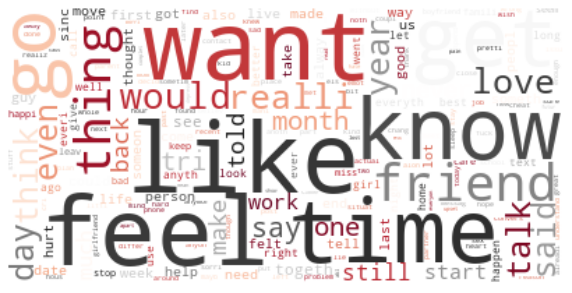

In [38]:
common_words = pd.DataFrame(train_data_features.toarray(), columns = vocab).sum().sort_values(ascending = False)

wordcloud = WordCloud(max_font_size=70,
                      max_words=200,
                      background_color="white",
                      colormap='RdGy')
wordcloud.generate_from_frequencies(frequencies=common_words)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### 4.2.2 comments
- common words across data: time, want, friend, know, like

# 5. Model

## 5.1 Baseline model

In [39]:
# Instantiate logistic regression model.
lr = LogisticRegression(solver = 'lbfgs', max_iter = 5000)

# Fit model to training data.
lr.fit(train_data_features, y_train)

# Evaluate model on training data.
print(f'Accuracy score for Train data set: {lr.score(train_data_features, y_train)}')

# Evaluate model on testing data.
print(f'Accuracy score for Test data set: {lr.score(test_data_features, y_test)}')

Accuracy score for Train data set: 0.996042216358839
Accuracy score for Test data set: 0.781578947368421


### 5.1 comments 
the train dataset has a much higher accuracy compared to test data, suggesting a overfitting of features

In [40]:
preds = lr.predict(test_data_features)
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


print(f'Specificity: {round(tn / (tn + fp),4)}')
print(f'Sensitivity: {round(tp / (tp + fn),4)}')

Specificity: 0.7701
Sensitivity: 0.7927


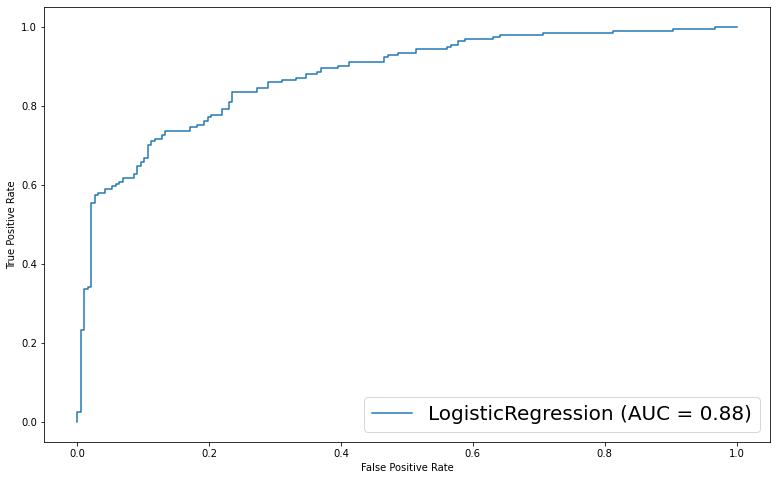

In [41]:
fig, ax = plt.subplots(figsize=(13, 8))
plot_roc_curve(lr, test_data_features, y_test, ax = ax)
plt.legend(prop={"size":20});

## 5.2 Testing with different transformer

### 5.2.1 CountVectorizer Logistic Regression

In [42]:
# Setting pipeline for two stages
cvec_lr = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'cvec__max_features': [5000, 6000, 7000],
    'cvec__min_df': [3, 4, 5],
    'cvec__max_df': [.4 ,.5, .6],
    'cvec__ngram_range': [(1,1), (1,2)]
}

gs_cvec_lr = GridSearchCV(cvec_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.
t0 = time()
gs_cvec_lr.fit(clean_train_text, y_train)
cvec_test_time = time() - t0
print(f'Best CVEC Parameters: {gs_cvec_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % cvec_test_time);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   24.4s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   34.5s finished


Best CVEC Parameters: CountVectorizer(max_df=0.4, max_features=7000, min_df=4, ngram_range=(1, 2))
Fit time:  35.304s


### 5.2.2 TFIDVectorizer Logistic Regression

In [43]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [3000, 4000, 5000],
    'tfid__min_df': [1, 2, 3],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(clean_train_text, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:   25.0s finished


Best TFID Parameters: TfidfVectorizer(max_df=0.3, max_features=5000)
Fit time:  25.365s


### 5.2.3 HashingVectorizer Logistic Regression

In [44]:
# Setting pipeline for two stages
hash_lr = Pipeline([
    ('hash', HashingVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'hash__n_features': [4000, 5000, 6000],
    'hash__ngram_range': [(1,1), (1,2)]
}

gs_hash_lr = GridSearchCV(hash_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.

t0 = time()
gs_hash_lr.fit(clean_train_text, y_train)
hash_test_time = time() - t0
print(f'Best HASH Parameters: {gs_hash_lr.best_estimator_[0]}')
print('Fit time:  %0.3fs' % hash_test_time);

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Best HASH Parameters: HashingVectorizer(n_features=5000)
Fit time:  2.559s


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.3s finished


### 5.2.4 R2 Scores & ROC AUC Plot (Vectorizer)

In [45]:
summary = []

summary.append(['LogisticRegression', 'CountVectorizer',
                gs_cvec_lr.best_score_,gs_cvec_lr.score(clean_test_text,y_test), round(cvec_test_time)])

summary.append(['LogisticRegression', 'TFIDVectorizer', 
                gs_tfid_lr.best_score_,gs_tfid_lr.score(clean_test_text,y_test), round(tfid_test_time)])

summary.append(['LogisticRegression', 'HashingVectorizer', 
                gs_hash_lr.best_score_,gs_hash_lr.score(clean_test_text,y_test), round(hash_test_time)])

pd.DataFrame(summary, 
             columns = ['model', 
                        'vectorizer', 
                        'train_score', 
                        'test_score', 
                        'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,time(s)
0,LogisticRegression,CountVectorizer,0.815963,0.810526,35
1,LogisticRegression,TFIDVectorizer,0.852886,0.807895,25
2,LogisticRegression,HashingVectorizer,0.821880,0.786842,3


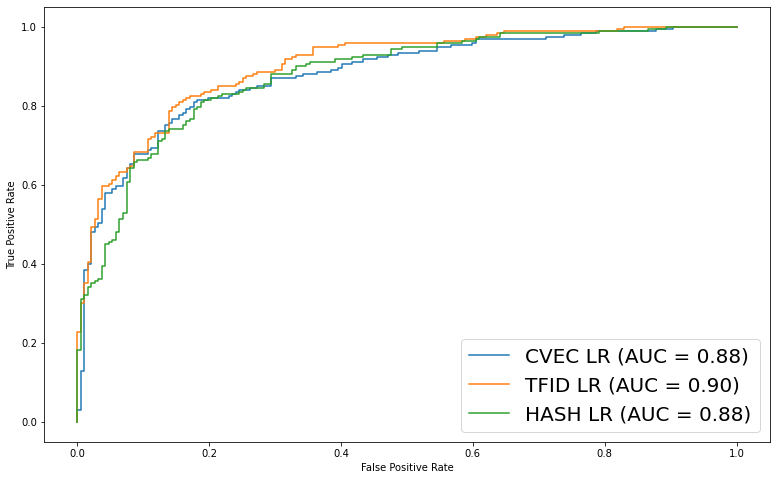

In [46]:
fig, ax = plt.subplots(figsize=(13, 8))
cvec_lr_disp = plot_roc_curve(gs_cvec_lr, clean_test_text, y_test, name = 'CVEC LR', ax = ax)
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, clean_test_text, y_test, name = 'TFID LR', ax = ax)
hash_lr_disp = plot_roc_curve(gs_hash_lr, clean_test_text, y_test, name = 'HASH LR', ax = ax)
plt.legend(prop={"size":20});

optimally, using TFID seems to return better result, will attempt to loop through different models to see which is better

## 5.3 Testing with different models
### 5.3.1 TFIDVectorizer LogisticRegression (Hyperparameter for model)

In [47]:
# Setting pipeline for two stages
tfid_lr = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs', max_iter = 5000))
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__min_df': [2, 3, 4],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)],
    'lr__C': list(np.linspace(2.5, 3.5, 5))
}

gs_tfid_lr = GridSearchCV(tfid_lr, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.
t0 = time()
gs_tfid_lr.fit(clean_train_text, y_train)
tfid_test_time = time() - t0
print(f'Best TFID Parameters: {gs_tfid_lr.best_estimator_}')
print('Fit time:  %0.3fs' % tfid_test_time);

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  2.3min finished


Best TFID Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=3000, min_df=4)),
                ('lr', LogisticRegression(C=2.5, max_iter=5000))])
Fit time:  138.401s


### 5.3.2 TFIDVectorizer KNeighborsClassifier

In [48]:
# Setting pipeline for two stages
tfid_knn = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000,4000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)],
    'knn__n_neighbors': [30, 50, 100]
}

gs_tfid_knn = GridSearchCV(tfid_knn, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.

t0 = time()
gs_tfid_knn.fit(clean_train_text, y_train)
knn_test_time = time() - t0
print(f'Best KNN Parameters: {gs_tfid_knn.best_estimator_}')
print('Fit time:  %0.3fs' % knn_test_time);

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.0s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  1.2min finished


Best KNN Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=4000, min_df=3,
                                 ngram_range=(1, 2))),
                ('knn', KNeighborsClassifier(n_neighbors=100))])
Fit time:  72.463s


### 5.3.3 TFIDVectorizer MultinomialNB
- MultinomialNB is the best choice here, as the X Variables are all integer counts

In [49]:
# Setting pipeline for two stages
tfid_nb = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.3, .4, .5],
    'tfid__ngram_range': [(1,1), (1,2)],
    'nb__alpha': list(np.linspace(0.1,1,3))
}

gs_tfid_nb = GridSearchCV(tfid_nb, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.

t0 = time()
gs_tfid_nb.fit(clean_train_text, y_train)
nb_test_time = time() - t0
print(f'Best NB Parameters: {gs_tfid_nb.best_estimator_}')
print('Fit time:  %0.3fs' % nb_test_time);

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   35.6s


Best NB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.5, max_features=2000, min_df=3)),
                ('nb', MultinomialNB())])
Fit time:  43.863s


[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:   43.6s finished


### 5.3.4 TFIDVectorizer SVC

In [50]:
# Setting pipeline for two stages
tfid_svc = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('svc', SVC())
])

pipe_params = {
    'tfid__max_features': [4000, 5000, 6000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.2, .3, .4],
    'tfid__ngram_range': [(1,1), (1,2)]
}

gs_tfid_svc = GridSearchCV(tfid_svc, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.

t0 = time()
gs_tfid_svc.fit(clean_train_text, y_train)
svc_test_time = time() - t0
print(f'Best NB Parameters: {gs_tfid_svc.best_estimator_}')
print('Fit time:  %0.3fs' % svc_test_time);

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.6s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.2min finished


Best NB Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=4000, min_df=3)),
                ('svc', SVC())])
Fit time:  72.741s


### 5.3.5 TFIDVectorizer DecisionTreeClassifier

In [51]:
# Setting pipeline for two stages
tfid_cart = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('cart', DecisionTreeClassifier())
])

pipe_params = {
    'tfid__max_features': [1000, 2000, 3000],
    'tfid__min_df': [2, 3],
    'tfid__max_df': [.3, .4],
    'tfid__ngram_range': [(1,1), (1,2)],
    'cart__min_samples_split': [50, 100, 200],
    'cart__ccp_alpha': [0, 0.001]
}

gs_tfid_cart = GridSearchCV(tfid_cart, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.

t0 = time()
gs_tfid_cart.fit(clean_train_text, y_train)
cart_test_time = time() - t0
print(f'Best CART Parameters: {gs_tfid_cart.best_estimator_}')
print('Fit time:  %0.3fs' % cart_test_time);

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   47.9s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.3min finished


Best CART Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.3, max_features=1000, min_df=3,
                                 ngram_range=(1, 2))),
                ('cart',
                 DecisionTreeClassifier(ccp_alpha=0, min_samples_split=200))])
Fit time:  77.911s


### 5.3.6 TFIDVectorizer BaggingClassifier

In [52]:
# Setting pipeline for two stages
tfid_bag = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('bag', BaggingClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__min_df': [4, 5, 6],
    'tfid__max_df': [.4, .5, .6],
    'tfid__ngram_range': [(1,2)],
    'bag__n_estimators': [10,20],
}

gs_tfid_bag = GridSearchCV(tfid_bag, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.
t0 = time()
gs_tfid_bag.fit(clean_train_text, y_train)
bag_test_time = time() - t0
print(f'Best BAG Parameters: {gs_tfid_bag.best_estimator_}')
print('Fit time:  %0.3fs' % bag_test_time);

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.7min finished


Best BAG Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.6, max_features=3000, min_df=5,
                                 ngram_range=(1, 2))),
                ('bag', BaggingClassifier(n_estimators=20))])
Fit time:  164.031s


### 5.3.7 TFIDVectorizer ADABoostClassifier

In [53]:
# Setting pipeline for two stages
tfid_ada = Pipeline([
    ('tfid', TfidfVectorizer()),
    ('ada', AdaBoostClassifier())
])

pipe_params = {
    'tfid__max_features': [2000, 3000, 4000],
    'tfid__min_df': [3, 4, 5],
    'tfid__max_df': [.3, .4, .5],
    'ada__n_estimators': [50, 100, 150],
    'ada__learning_rate': [0.9, 1, 1.1]
}

gs_tfid_ada = GridSearchCV(tfid_ada, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5, verbose = 1, n_jobs = -1) # 5-fold cross-validation.
t0 = time()
gs_tfid_ada.fit(clean_train_text, y_train)
ada_test_time = time() - t0
print(f'Best ADABoost Parameters: {gs_tfid_ada.best_estimator_}')
print('Fit time:  %0.3fs' % ada_test_time);

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   41.4s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  6.4min finished


Best ADABoost Parameters: Pipeline(steps=[('tfid',
                 TfidfVectorizer(max_df=0.4, max_features=2000, min_df=3)),
                ('ada',
                 AdaBoostClassifier(learning_rate=0.9, n_estimators=150))])
Fit time:  384.196s


### 5.3.8 R2 Scores & ROC AUC Plot (Model)

In [54]:
summary = []

summary.append(['LogisticRegression', 'TFIDVectorizer',
                gs_tfid_lr.best_score_,gs_tfid_lr.score(clean_test_text,y_test), round(tfid_test_time)])

summary.append(['KNN', 'TFIDVectorizer',
                gs_tfid_knn.best_score_, gs_tfid_knn.score(clean_test_text,y_test), round(knn_test_time)])

summary.append(['MultinomialNB', 'TFIDVectorizer',
                gs_tfid_nb.best_score_,gs_tfid_nb.score(clean_test_text,y_test), round(nb_test_time)])

summary.append(['SVC', 'TFIDVectorizer',
                gs_tfid_svc.best_score_,gs_tfid_svc.score(clean_test_text,y_test), round(svc_test_time)])

summary.append(['CART', 'TFIDVectorizer',
                gs_tfid_cart.best_score_, gs_tfid_cart.score(clean_test_text,y_test), round(cart_test_time)])

summary.append(['BaggingClassifier', 'TFIDVectorizer',
                gs_tfid_bag.best_score_,gs_tfid_bag.score(clean_test_text,y_test), round(bag_test_time)])

summary.append(['ADABoost', 'TFIDVectorizer',
                gs_tfid_ada.best_score_,gs_tfid_ada.score(clean_test_text,y_test), round(ada_test_time)])

pd.DataFrame(summary, columns = ['model', 
                                 'vectorizer', 
                                 'train_score',
                                 'test_score', 
                                 'time(s)']).style.highlight_max().highlight_min(color = 'red')

,model,vectorizer,train_score,test_score,time(s)
0,LogisticRegression,TFIDVectorizer,0.848940,0.823684,138
1,KNN,TFIDVectorizer,0.830465,0.818421,72
2,MultinomialNB,TFIDVectorizer,0.849603,0.847368,44
3,SVC,TFIDVectorizer,0.851555,0.805263,73
4,CART,TFIDVectorizer,0.704468,0.671053,78
5,BaggingClassifier,TFIDVectorizer,0.773736,0.744737,164
6,ADABoost,TFIDVectorizer,0.777725,0.784211,384


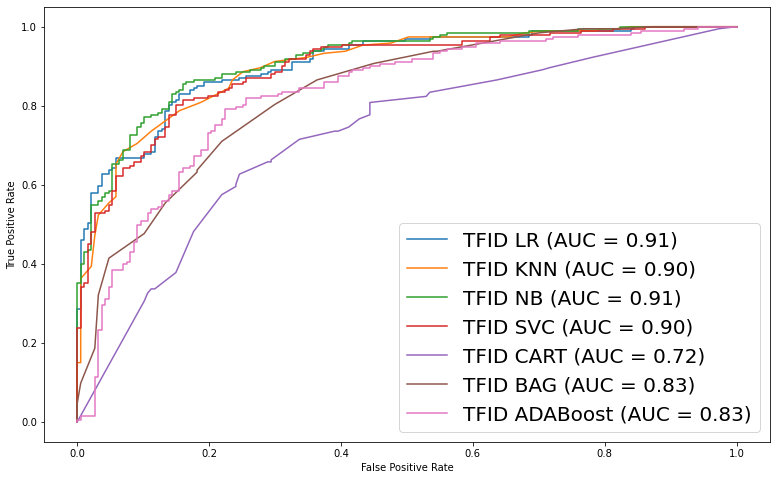

In [55]:
fig, ax = plt.subplots(figsize=(13, 8))
tfid_lr_disp = plot_roc_curve(gs_tfid_lr, clean_test_text, y_test, name = 'TFID LR', ax = ax)
tfid_knn_disp = plot_roc_curve(gs_tfid_knn, clean_test_text, y_test, name = 'TFID KNN', ax = tfid_lr_disp.ax_)
tfid_nb_disp = plot_roc_curve(gs_tfid_nb, clean_test_text, y_test, name = 'TFID NB', ax = tfid_lr_disp.ax_)
tfid_svc_disp = plot_roc_curve(gs_tfid_svc, clean_test_text, y_test, name = 'TFID SVC', ax = tfid_lr_disp.ax_)
tfid_cart_disp = plot_roc_curve(gs_tfid_cart, clean_test_text, y_test, name = 'TFID CART', ax = tfid_lr_disp.ax_)
tfid_bag_disp = plot_roc_curve(gs_tfid_bag, clean_test_text, y_test, name = 'TFID BAG', ax = tfid_lr_disp.ax_)
tfid_ada_disp = plot_roc_curve(gs_tfid_ada, clean_test_text, y_test, name = 'TFID ADABoost', ax = tfid_lr_disp.ax_)
plt.legend(prop={"size":20});

#### 5.3.8 comments:
- TFID NB has the best ROC AUC Score
- Will use LogisticRegression for the final analysis, as it will better tell us the importance of certain keywords from threads

## 5.4 Confusion Matrix

Comparing model between NaiveBayes and LogisticRegression

In [56]:
# preparing scoring table for dataframe
confuse = []


predictions = gs_tfid_lr.predict(clean_test_text)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
confuse.append(['LogisticRegression', tn, fp, fn, tp, round(tp / (tp + fn),4),round(tn / (tn + fp),2)])

predictions = gs_tfid_nb.predict(clean_test_text)
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
confuse.append(['MultinomialNB', tn, fp, fn, tp, round(tp / (tp + fn),4), round(tn / (tn + fp),2)])

In [57]:
pd.DataFrame(confuse, 
             columns = ['model',
                        'TN', 
                        'FP', 
                        'FN', 
                        'TP', 
                        'T1_acc', 
                        'T2_acc']).style.highlight_max()

,model,TN,FP,FN,TP,T1_acc,T2_acc
0,LogisticRegression,146,41,26,167,0.865300,0.780000
1,MultinomialNB,156,31,27,166,0.860100,0.830000


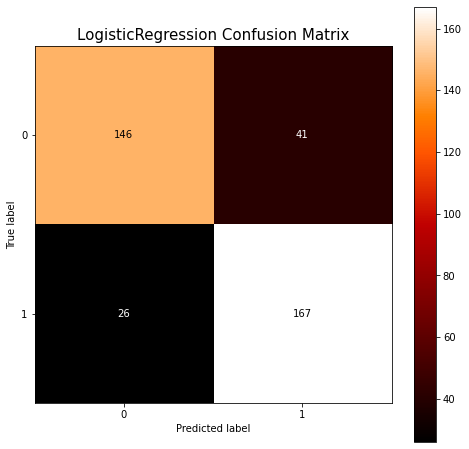

In [58]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('LogisticRegression Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_lr, clean_test_text, y_test, ax = ax, cmap='gist_heat');

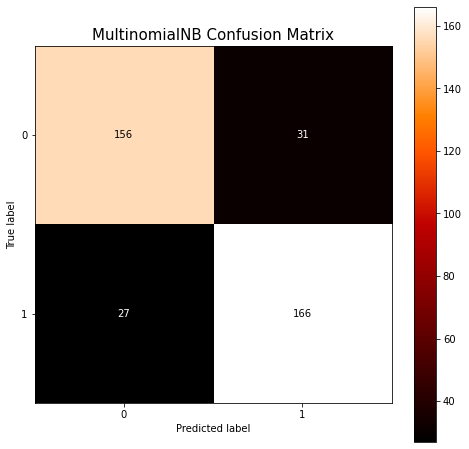

In [59]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.title('MultinomialNB Confusion Matrix', fontdict = {'fontsize': 15})
plot_confusion_matrix(gs_tfid_nb, clean_test_text, y_test, ax = ax, cmap='gist_heat');

### 5.4 comments
- LogisticRegression model is better at predicting thread 1
- MultinomialNB model is better at predicting thread 2
- MultinomialNB model does the predicting overall
- LogisticRegression model predict worst for thread 2 compared to baseline model, despite a improvement in predicting thread 1

# 6. Analysis and Recommendation

In [60]:
thread_1_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = False).reset_index(drop = True)

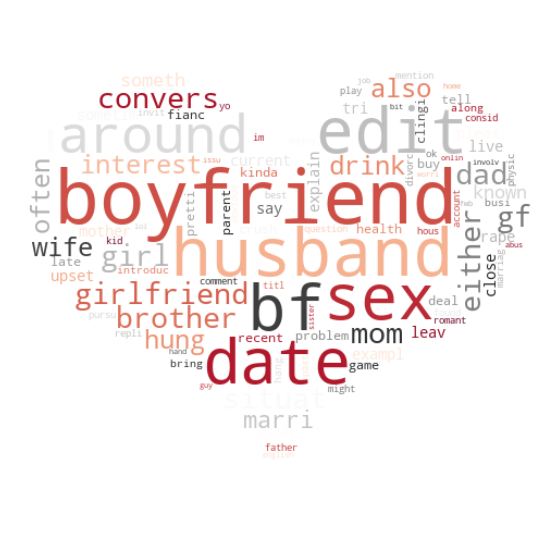

In [61]:
d = {}
for a, x in thread_1_bag.values:
    d[a] = x

mask = np.array(Image.open('../images/heart.jpg'))

wordcloud = WordCloud(max_font_size=70,
                      max_words=100,
                      background_color="white",
                      colormap='RdGy',
                      mask = mask)
wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [62]:
thread_2_bag = pd.DataFrame(data = [gs_tfid_lr.best_estimator_.named_steps['tfid'].get_feature_names(),
                     gs_tfid_lr.best_estimator_.named_steps['lr'].coef_[0]]).T.rename(columns = {0 : 'Features', 1: 'Coef'}).sort_values(by = 'Coef', ascending = True).reset_index(drop = True)

In [63]:
thread_2_bag['Coef'] = thread_2_bag['Coef']*-1

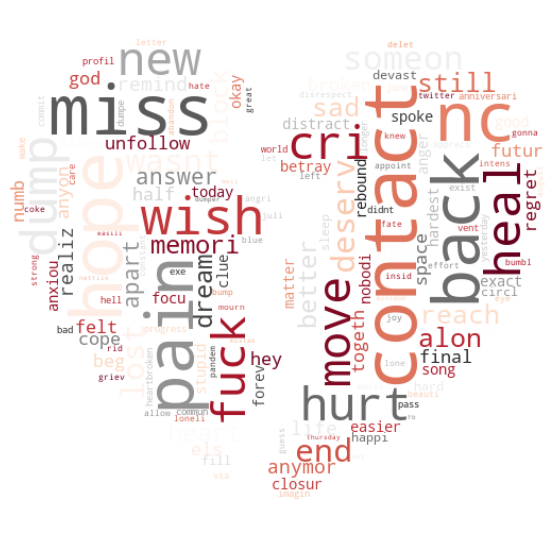

In [64]:
d = {}
for a, x in thread_2_bag.values:
    d[a] = x

mask = np.array(Image.open('../images/heartbreak.jpg'))

wordcloud = WordCloud(max_font_size=70,
                      max_words=150,
                      background_color="white",
                      colormap='RdGy',
                      mask = mask)

wordcloud.generate_from_frequencies(frequencies=d)
plt.figure(figsize = (10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

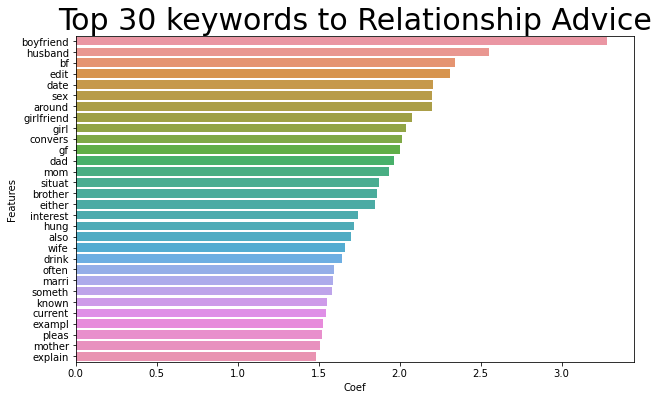

In [65]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 keywords to Relationship Advice',fontdict = {'fontsize': 30})
sns.barplot(x = thread_1_bag['Coef'][:30], y = thread_1_bag['Features'][:30]);

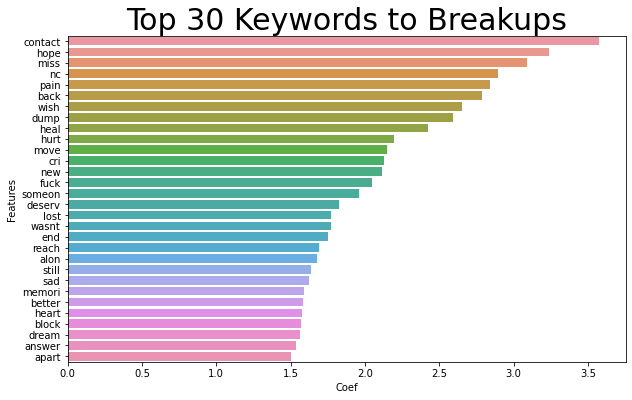

In [66]:
plt.figure(figsize= (10, 6))
plt.title('Top 30 Keywords to Breakups',fontdict = {'fontsize': 30})
sns.barplot(x = thread_2_bag['Coef'][:30], y = thread_2_bag['Features'][:30]);

## 6.1 Checking Misclassified post

In [67]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_tfid_nb.predict(clean_test_text), columns=['predicted'], index = y_test.index)

# Create column for observed values.
results['actual'] = y_test

# Check out first five rows.
results.head()

,predicted,actual
653,1,1
748,1,1
318,0,1
1272,0,0
14,1,1


In [68]:
# Find all indices where predicted and true results 
# aren't the same, then save in an array.
row_ids = results[results['predicted']!= results['actual']].index
row_ids

Int64Index([ 318,  434,  903, 1769,  516,  172,  690,  724, 1488, 1733, 1448,
             418, 1370,  606,  587,  193,   25, 1206, 1178,  477, 1094, 1820,
            1792, 1746,  531, 1440, 1835, 1124, 1740, 1353, 1528,  512, 1755,
             258, 1194,  319, 1456, 1732,  260,  925,  419,  829,  754, 1874,
            1181,  333, 1706,  644, 1576, 1627, 1736, 1026,  919, 1438,  799,
             547, 1055, 1435],
           dtype='int64')

### 6.1.1 Misclassified post 1

In [74]:
i = 31
print(f'Post ID: {row_ids[i]}') #512
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 512
----
So I dated this girl 2 years older then me I am 21 she was 23 at the time going to be 24 on sept 15th (funny how I can remember her birthday but she cant remember mine this was a little insight. She never remembered my birthday or my middle name) Long story short we broke up because I accused her of not being at work and possibly doing some shady things. She received flowers from someone else and when I asked her about them when I came over one night her response was "why are you asking so many questions about this" a couple days later I come to visit her at work and bring her food for lunch and I miss her car (parking lot is weirdly shapped and theres spots you can park in and not be seen) I accussed her of not being at work and bring up the fact she seemed really shady about the flowers. Like why didnt you tell me this during the day why did you wait till I came over at 11pm to let me find out about them on my own. She breaks up with me tells me " I am crazy and sup

This post is can be classified as a breakup post due to the nature of it.

### 6.1.2 Misclassified post 2

In [75]:
i = 23
print(f'Post ID: {row_ids[i]}') #1746
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 1746
----
Guys I can really use some help right now. My GF and I have only been dating for 4 months and we broke up about a week ago. We’ve been talking ever sense and she just doesn’t feel the same way anymore and that I’m better off finding someone who can match my energy. A day has gone by and I’m struggling bad. She came from an mentally and physically abusive relationship before me for 6 years. She said I’ve done everything perfectly for her and that I was the best man in her entire life (her dad was never around.) I don’t understand how it can be so great, ex. we never fought once, we played video games together, liked the same music, I always opened the car door for her etc. but she still wanted to end it? What should I do? This girl is unlike no other and I don’t want to lose her but I feel like she’s gone for good.
----
Actual thread: 0


This can be interpreted as a relationship advice post, as the author is trying to get back the relationship

### 6.1.3 Misclassified post 3

In [76]:
i = 41
print(f'Post ID: {row_ids[i]}') #829
print('----')
print(X_test[row_ids[i]])
print('----')
print(f'Actual thread: {y_test[row_ids[i]]}')

Post ID: 829
----
Lately I have been dreaming of my ex every night. He broke up with me over a year ago and was the first person I slept with. I really like him and wish things were different. 
We had been talking a little but not for the last couple months. I have been really upset about getting broken up with.
Now I am suddenly dreaming about him every night. The dreams are usually good so its kinda nice. I sometimes have had dreams about exes but not this much and this long after a breakup. What is going on?
----
Actual thread: 1


This is more suitable to be a breakup post

# 6.2 Recommendations

### Problem Statement
- Create a classification model to determine the nature of the text being relationship advice or breakup.

### Accuracy of models
- MultinomialNB 
  - 86% for relationship_advice 
  - 83% for BreakUp
- LogisticRegression
  - 86.5% for relationship_advice 
  - 78% for BreakUp

### Key findings

- The findings shown that Relationship_advice tend to mention more about the other person(Boyfriend,spouse,wife,gf,bf) as opposed to Breakup when it is more self focused(dream, memory,sad, better, move on).
- There is a small misclassification of the model, and after taking a manual check on the post, it can be interpreted that the post would have been better classified under the opposite thread instead. 
- Its interesting to note that around the 6am - 12pm time period, not much relationship advices are posted. This interpretation would be better look into by a psychology specialist to see if there is a relationship in time of post with the content.

### Limitations
- There is some limitation to the data, as we are scraping through reddit posts, there is a chance of misclassification as mentioned before, where the public post a different content in the wrong thread. what can be done is to restrict the posting with moderators and ensure the content is align with the thread before it is posted, to ensure the content is correct to the thread mentioned.

- This is also a limitation of the amount of gridsearch we can do, as adding more variables will require a much longer computational time, which is not optimal for this project.

### For further research
- We can further this project by adding more classification group to the data( e.g. marriage advice, family relationship etc etc.) to make a more intricate classification model.
- consider scrapping text data from other medias(twitter, forums, facebook)
